In [ ]:
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
file = 'soil_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)

with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./')
os.remove(file)

In [ ]:
training_data_directory = 'train'
test_data_directory = 'test'

In [ ]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 75 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [ ]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 20
MODEL_NAME = 'soil'

In [ ]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3184 - loss: 3.3815 - val_accuracy: 0.3333 - val_loss: 2.6500
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.3668 - loss: 2.0712 - val_accuracy: 0.4667 - val_loss: 2.1255
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3858 - loss: 1.7947 - val_accuracy: 0.3333 - val_loss: 1.1286
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3538 - loss: 1.0928 - val_accuracy: 0.3333 - val_loss: 1.2261
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4091 - loss: 0.9086 - val_accuracy: 0.5333 - val_loss: 0.8918
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6190 - loss: 0.9095 - val_accuracy: 0.6667 - val_loss: 0.8652
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8007 - loss: 0.8898 - val_accuracy: 0.6000 - val_loss: 0.8128
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5729 - loss: 0.8108 - val_accuracy: 0.6000 - val_loss: 1.0013
Epoch 9/20


In [ ]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = ["Gravel", "Sand", "Silt"] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]

    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""

    return out

In [ ]:
soil_type_you_need = input("Enter the soil type:")
soil_number = int(input("Enter the number of images you need:"))
print_soil = (f"/{soil_type_you_need}/{soil_number}.jpg")
print_soil

Enter the soil type:Sand
Enter the number of images you need:1


'/Sand/1.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Soil Type: Sand
    True Soil Type: Sand
    Correct?: True


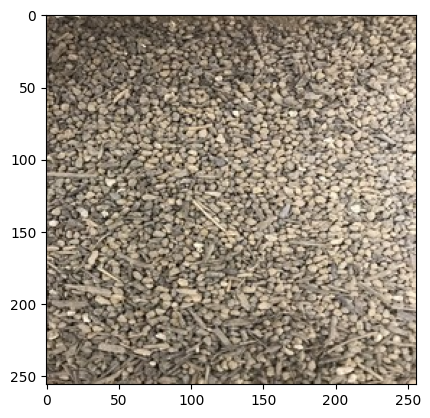

In [ ]:
test_images = [f for f in listdir(test_data_directory) if isfile(join(test_data_directory, f))]
test_image_filepath = test_data_directory + r'/Sand/0.jpg'
print(make_prediction(test_image_filepath))

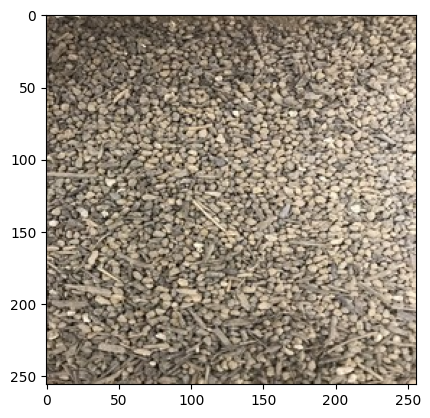

In [ ]:
percentage_photo = test_data_directory + r'/Sand/0.jpg'
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])

In [ ]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            # For cropping images
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

In [ ]:
try:
    parent = training_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training images
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('train', 'train_divided'))
    # split test images
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('test', 'test_divided'))
except FileExistsError:
    pass

In [ ]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/content/soil.h5


In [ ]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array


def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 255.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))

    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
---
Percent Gravel: 100.0%)
Percent Sand: 0.0%)
Percent Silt: 0.0%)
Time to Classify: 1.03427 seconds
---


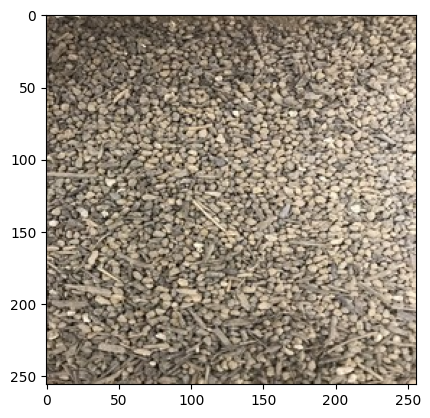

In [ ]:
classify_percentage(image_fp=percentage_photo)